## this is a modified copy of my origional that i will be exploring what the data look like if we include +/short patients and convert them to -/short. 1/7/19

# imputation and modeling
sklearn modeling the median imputed training data using min/max clinically guided aggregation. 
preprocessing includes variable formatting (categorical to factor variables in r, train/test split, and median imputation).


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
from pathlib import Path
import seaborn as sns
import numpy as np
import glob
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, auc, precision_recall_fscore_support, pairwise, f1_score, log_loss, make_scorer
from sklearn.metrics import precision_score, recall_score
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.joblib import Memory
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, Imputer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.utils import validation
from scipy.sparse import issparse
from scipy.spatial import distance
from sklearn import svm

#importin xg boost and all needed otherstuff
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier #conda install -c conda-forge xgboost to install
##adding these, lets see if it helps with xgboost crash
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#reducing warnings that are super common in my model
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.simplefilter(action='ignore') #ignore all warnings

#memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

RANDOM_STATE = 15485867

%matplotlib inline
plt.style.use('seaborn-white')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

## importing datasets and doing final formatting/processing

In [2]:
#patients of interest from rotation_cohort_generation
from parameters import final_pt_df_v, date, repository_path, lower_window, upper_window, folder, date, time_col, time_var, patient_df, categorical, save_boolean
#patients of interest from rotation_cohort_generation
final_pt_df2 = final_pt_df_v #pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/%s_final_pt_df2.csv'%(most_updated_patient_df), index_col=0)
del(final_pt_df_v)

patients= list(final_pt_df2['subject_id'].unique())
hadm_id= list(final_pt_df2['hadm_id'].unique())
icustay_id= list(final_pt_df2['icustay_id'].unique())
icustay_id= [int(x) for x in icustay_id]

time: 1.02 s


In [3]:
len(patients)

15412

time: 4.45 ms


In [4]:
len(icustay_id)

19633

time: 2.94 ms


In [5]:
folder

'24_hr_window'

time: 2.02 ms


In [6]:
# ###########
# save_boolean=False
# ############

time: 300 µs


In [7]:
address=str(repository_path)+'/data/cleaned_merged_agg/'+'%s/'%(folder)
train_data= pd.read_csv(Path(address+'%s_%s_cleaned_merged_agg.csv' %(date, 'train')), index_col=0)
test_data= pd.read_csv(Path(address+'%s_%s_cleaned_merged_agg.csv' %(date, 'test')), index_col=0)

time: 109 ms


In [8]:
### added 11/8/19: removed daily sofa score from prediction model, since the components used to calculate it are already in model
### 12/12/19:  #removing o2_flow since it is mostly sparce and is not a helpful variable
train_data.drop('daily_sofa', axis=1, inplace=True)
test_data.drop('daily_sofa', axis=1, inplace=True)
train_data.drop('o2_flow', axis=1, inplace=True)
test_data.drop('o2_flow', axis=1, inplace=True)
categorical.remove('o2_flow')

time: 9.79 ms


In [9]:
train_data['pao2fio2ratio'].head()

0    0.145556
1    0.087095
2    0.017347
3    0.145556
4    0.145556
Name: pao2fio2ratio, dtype: float64

time: 3.35 ms


## getting descriptive numbers for publication

In [10]:
final_pt_df2.head()#['icustay_id'].nunique()

,icustay_id,ssc_charttime,ssc_id,icu_admit,ab_id,ab_start,ab_end,ab_ssc_delta,t_0,t_end,...,subject_id,dod_hosp,dod_ssn,ab_course,org_list,spec_type_list,first_pos_else_neg_ssc,sc_result,final_bin,hadm_id
0,294638,2191-03-16 00:00:00,22,2191-03-16 00:29:31,1213116,2191-03-16,2191-03-22,0 days 00:00:00.000000000,2191-03-16,2191-03-22,...,4,NaN,NaN,full,STAPH AUREUS COAG +,BLOOD CULTURE,2191-03-16 00:00:00,positive,C_pos/A_full,185777
1,220597,2149-11-10 09:40:00,45,2149-11-09 13:07:02,2089126,2149-11-10,2149-11-15,0 days 00:00:00.000000000,2149-11-10,2149-11-15,...,9,2149-11-14,2149-11-14,full,NaN,NaN,2149-11-10 09:40:00,negative,C_neg/A_full,150750
2,232669,2104-08-11 00:00:00,60,2104-08-08 02:08:17,616189,2104-08-11,2104-08-12,0 days 00:00:00.000000000,2104-08-11,2104-08-12,...,12,2104-08-20,2104-08-20,partial,NaN,NaN,2104-08-11 00:00:00,negative,C_neg/A_partial,112213
3,273430,2108-08-05 20:42:00,69,2108-08-05 16:26:09,2572274,2108-08-06,2108-08-08,1 days 00:00:00.000000000,2108-08-06,2108-08-08,...,19,NaN,2109-08-18,partial,NaN,NaN,2108-08-05 20:42:00,negative,C_neg/A_partial,109235
4,217847,2134-09-11 09:35:00,70,2134-09-11 20:50:04,1388217,2134-09-12,2134-09-13,1 days 00:00:00.000000000,2134-09-12,2134-09-13,...,21,2135-02-08,2135-02-08,full,NaN,NaN,2134-09-11 09:35:00,negative,C_neg/A_full,109451


time: 29.6 ms


In [11]:
final_pt_df2.loc[final_pt_df2['final_bin'].isin(['C_neg/A_partial','C_pos/A_full','C_pos/A_partial']),'subject_id'].nunique()

10290

time: 5.1 ms


In [12]:
list(train_data)

['icustay_id',
 'bilirubin',
 'bun',
 'chloride',
 'creatinine',
 'glucose',
 'heartrate',
 'inr',
 'lactate',
 'potassium',
 'ptt',
 'resprate',
 'sum_elix',
 'temperature',
 'weight',
 'yearsold',
 'bicarbonate',
 'diasbp',
 'hemoglobin',
 'meanartpress',
 'mingcs',
 'pao2fio2ratio',
 'ph',
 'platelet',
 'spo2',
 'sysbp',
 "('max', 'calcium')",
 "('max', 'sodium')",
 "('max', 'wbc')",
 "('min', 'calcium')",
 "('min', 'sodium')",
 "('min', 'wbc')",
 'any_vasoactives',
 'bands',
 'cancer_elix',
 'dobutamine',
 'dopamine',
 'epinephrine',
 'ethnicity',
 'gender',
 'leukocyte',
 'nitrite',
 'norepinephrine',
 'pco2',
 'phenylephrine',
 'rrt',
 'vasopressin',
 'vent_recieved']

time: 2.44 ms


In [13]:
full_demo=pd.concat([train_data[['icustay_id','yearsold','ethnicity','gender']],test_data[['icustay_id','yearsold','ethnicity','gender']]])

time: 4.78 ms


In [14]:
full_demo.describe()

,icustay_id,yearsold
count,10305.000000,10305.000000
mean,249857.183212,-0.018518
std,28968.046750,0.094015
min,200012.000000,-0.417086
25%,224498.000000,-0.063945
50%,249804.000000,0.002141
75%,275055.000000,0.052154
max,299995.000000,0.094968


time: 25.4 ms


In [15]:
full_demo.head()

,icustay_id,yearsold,ethnicity,gender
0,200012.0,-0.206692,asian,F
1,200014.0,0.074783,unknown/other,M
2,200033.0,0.004945,white/nonhispanic,M
3,200036.0,0.037873,white/nonhispanic,M
4,200055.0,-0.219450,black,F


time: 7.95 ms


In [16]:
full_demo.merge(final_pt_df2[['icustay_id','subject_id','final_bin']])['final_bin'].value_counts()

C_neg/A_partial    7867
C_pos/A_full       2438
Name: final_bin, dtype: int64

time: 20.4 ms


In [17]:
full_demo['yearsold'].min()

-0.41708575475214704

time: 2.91 ms


In [18]:
full_demo['ethnicity'].value_counts()

white/nonhispanic    7472
black                1130
unknown/other         995
hispanic              433
asian                 275
Name: ethnicity, dtype: int64

time: 4.8 ms


In [19]:
full_demo['gender'].value_counts()

M    5706
F    4599
Name: gender, dtype: int64

time: 6.06 ms


In [20]:
full_demo['gender'].value_counts()

M    5706
F    4599
Name: gender, dtype: int64

time: 6.42 ms


In [21]:
test_data[['icustay_id','yearsold','ethnicity','gender']].head()

,icustay_id,yearsold,ethnicity,gender
0,200030.0,-0.057816,black,M
1,200063.0,-0.171266,unknown/other,M
2,200078.0,-0.002132,white/nonhispanic,M
3,200109.0,0.025988,unknown/other,M
4,200116.0,-0.045266,white/nonhispanic,M


time: 8.89 ms


In [22]:
train_data.merge(final_pt_df2[['icustay_id','subject_id','final_bin']])['final_bin'].value_counts()

C_neg/A_partial    5512
C_pos/A_full       1693
Name: final_bin, dtype: int64

time: 20.7 ms


In [23]:
final_pt_df2['final_bin'].value_counts()

C_neg/A_partial    7867
C_neg/A_full       7401
C_pos/A_full       2438
C_pos/A_partial    1927
Name: final_bin, dtype: int64

time: 5.44 ms


## back to the formatting and final preprocessing

In [24]:
def rename_fxn(data):
    """
    renames data columns to be more readable.
    """
    rename_dic={
    "('max', 'sodium')": "maxSodium" ,
    "('max', 'sodium')" : "maxSodium",
    "('min', 'sodium')" : "minSodium",
    "('max', 'calcium')" : "maxCalcium",
    "('min', 'calcium')" : "minCalcium",
    "('max', 'sodium')": "maxSodium",
    "('min', 'sodium')": "minSodium",
    "('max', 'wbc')": "maxWBC",
    "('min', 'wbc')": "minWBC"#,
#     "bands": "ibands",
#     "pco2": "ipco2"
        }
    data=data.rename(rename_dic, axis='columns').copy()
    return(data)

time: 1.02 ms


In [25]:
def last_minute_clean(data):
    "some last minute data cleaning steps that were missed prior to this. eventually should be transitioned to earlier in pipeline"
    data.loc[data['ethnicity'].isnull(), 'ethnicity']='unknown/other'
    data.loc[data['yearsold']>90,"yearsold"]=90
    return(data)

time: 736 µs


In [26]:
def standardize_fxn(data):
    """
    function operations:
    2) standardize last 2 columns to be standardized (weight and age)
    """
    from sklearn.impute import SimpleImputer
    
    ### I chose to standardize the weight and age here (after the feature_aggregation)... I can't remember why though. either way, it doesn't affect anything, but is a bit clunky. 
    weight_median=np.log(data.loc[data['final_bin']=="C_neg/A_partial","weight"]+1).median()
    weight_quant1=np.log(data.loc[data['final_bin']=="C_neg/A_partial","weight"]+1).quantile(0.25)#.between(train_data['col'].quantile(.25), df['col'].quantile(.75), inclusive=True)]
    weight_quant3=np.log(data.loc[data['final_bin']=="C_neg/A_partial","weight"]+1).quantile(0.75)
    weight_iqr=weight_quant3-weight_quant1
    #print(weight_median,weight_quant3,weight_quant1, weight_iqr)

    age_median=np.log(data.loc[data['final_bin']=="C_neg/A_partial","yearsold"]+1).median()
    age_quant1=np.log(data.loc[data['final_bin']=="C_neg/A_partial","yearsold"]+1).quantile(0.25)
    age_quant3=np.log(data.loc[data['final_bin']=="C_neg/A_partial","yearsold"]+1).quantile(0.75)
    age_iqr=age_quant3-age_quant1

    #converting to log scaled standardized data for age/weight
    data['weight']=data['weight'].apply(lambda x: (np.log(x+1)-weight_median)/weight_iqr)
    data['yearsold']=data['yearsold'].apply(lambda x: (np.log(x+1)-age_median)/age_iqr)
    
    return(data)

time: 2.44 ms


In [27]:
def remap_categorical(data, categorical):
    """remapps the 0 and 1 back to interpretable values in the dataframe. useful to use before onehot encoding. also useful to fill in some missing values and nan's"""   

    remapping_dic={
    'vent_recieved':{0:'None', 2:'Mech' , 1:'OxygenTherapy', np.nan:'None'},
    'cancer_elix':{0:'no_cancer_cormorb', 1:'cancer_comorbidity'},
    'gender':{0:'F', 1:'M', np.nan:'NA'},
    'leukocyte':{0:'Neg/Not_tested' , 1:'pos'},
    'nitrite':{0:'Neg/Not_tested' , 1:'pos'},
    'rrt':{0:'not_recieved' , 1:'recieved'},
    'phenylephrine':{0:'not_recieved' , 1:'recieved'},
    'norepinephrine':{0:'not_recieved' , 1:'recieved'},
    'vasopressin':{0:'not_recieved' , 1:'recieved'},
    'dobutamine':{0:'not_recieved' , 1:'recieved'},
    'dopamine':{0:'not_recieved' , 1:'recieved'},
    'epinephrine':{0:'not_recieved' , 1:'recieved'},
    'any_vasoactives':{0:'not_recieved' , 1:'recieved'},
    'o2_flow':{0:'no_flow', 1:"recieved_O2"}
    }
    
    for col in list(data):
        if col in ['ethnicity', 'bands','pco2']:
            pass
        elif col in categorical:
            data[col]=data[col].replace(remapping_dic[col])
        
    return(data)

time: 1.94 ms


In [28]:
def onehotencoder(data, categorical):
    """
    function operations:
    3) convert categorical columns to proper format
    """

    data = pd.get_dummies(data, columns = categorical, drop_first=True)
    return(data)

time: 838 µs


In [29]:
def median_imputer(data, categorical):
    """
    function operations:
    4) median impute
    """
    from sklearn.impute import SimpleImputer
    
    #pop outcome off
    outcome= data.pop("final_bin").values
       
    #impute
    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    imp.fit(data[[x for x in list(data) if x not in categorical]]) 
    data[[x for x in list(data) if x not in categorical]]= imp.transform(data[[x for x in list(data) if x not in categorical]])
    
    #reattach outcome
    data['final_bin']= outcome
    return(data)

time: 1.55 ms


In [30]:
def preprocessing(data, encode=True):
    """
    function operations: (each one of the below steps uses one of the functions defined above.)
    1) rename columns
    2) some last minute cleanup
    3) standardize last 2 columns to be standardized
    4) median impute 
    5) remap categorical values to be interpretable and encode them for modeling
    6)
    """
    from sklearn.impute import SimpleImputer
    
    ###rename
    data=rename_fxn(data)
    
    ###some last minute data cleaning steps that were missed prior to this. eventually should be transitioned to earlier in pipeline
    data=last_minute_clean(data)
    
    ##scale & standardize the remaining 2 columns (age and weight)
    data=standardize_fxn(data)
    
    ### onehot encoding categorical var
    
    #remapping the 0 and 1 back to categorical values for more interpreable onehotencoding column headings
    data=remap_categorical(data, categorical)
    
    #impute
    data= median_imputer(data, categorical)
    
    #onehotencoding
    if encode==True:
        data=onehotencoder(data, categorical)
    
    #binarizing and poping outcome for training data
    data.loc[data['final_bin']=="C_pos/A_partial","final_bin"]=0 ####THIS IS THE BIGGEST CHANGE IN THIS NOTEBOOK
    data.loc[data['final_bin']=="C_pos/A_full","final_bin"]=1
    data.loc[data['final_bin']=="C_neg/A_partial","final_bin"]=0
    data['final_bin']=pd.to_numeric(data['final_bin'])
    
    ## establishing training data and labels
    x= data.copy()
    z_icustay_id=x.pop('icustay_id')
    y= x.pop("final_bin").values
    
    return(x, y, z_icustay_id)

time: 2.01 ms


# todo: get some statistics on missingness right before i perform imputation.

In [31]:
x_train, y_train, z_icustay_id = preprocessing(pd.merge(train_data, final_pt_df2[['icustay_id','final_bin']]))
x_test, y_test, z_icustay_id_test= preprocessing(pd.merge(test_data, final_pt_df2[['icustay_id','final_bin']]))

z_subject_id=pd.merge(pd.DataFrame(z_icustay_id), final_pt_df2[['icustay_id','subject_id']], how='left')['subject_id'] #7205

time: 367 ms


In [32]:
#y.reshape(1,-1).ravel()

time: 329 µs


In [33]:
x_train2, y_train2, z_icustay_id2 = preprocessing(pd.merge(train_data, final_pt_df2[['icustay_id','final_bin']]),encode=False)
x_test2, y_test2, z_icustay_id_test2= preprocessing(pd.merge(test_data, final_pt_df2[['icustay_id','final_bin']]),encode=False)


time: 304 ms


In [34]:
###checking distribution of all categorical variables
full_set=pd.concat([x_train2,x_test2])
for element in categorical:
    print("###{}###".format(element))
    print(full_set[element].value_counts(), '\n')

###ethnicity###
white/nonhispanic    7472
black                1130
unknown/other         995
hispanic              433
asian                 275
Name: ethnicity, dtype: int64 

###bands###
absent    9188
<10        688
>10        429
Name: bands, dtype: int64 

###pco2###
absent    7002
<50       2439
>50        864
Name: pco2, dtype: int64 

###any_vasoactives###
not_recieved    7567
recieved        2738
Name: any_vasoactives, dtype: int64 

###leukocyte###
Neg/Not_tested    9236
pos               1069
Name: leukocyte, dtype: int64 

###nitrite###
Neg/Not_tested    10095
pos                 210
Name: nitrite, dtype: int64 

###vent_recieved###
Oxygen    5007
Mech      4501
None       797
Name: vent_recieved, dtype: int64 

###dobutamine###
not_recieved    10229
recieved           76
Name: dobutamine, dtype: int64 

###gender###
M    5706
F    4599
Name: gender, dtype: int64 

###dopamine###
not_recieved    9873
recieved         432
Name: dopamine, dtype: int64 

###epinephrine###
not

In [35]:
len(full_set)

10305

time: 2.04 ms


#### quick qc to ensure the imputation and standardization of age/weight worked

In [36]:
train_data[['chloride','weight','yearsold']].head()

,chloride,weight,yearsold
0,NaN,-0.121245,-0.206692
1,0.037089,-0.064565,0.074783
2,-0.004314,-0.012014,0.004945
3,NaN,0.007438,0.037873
4,-0.035714,-0.094731,-0.219450


time: 6.75 ms


In [37]:
x_train[['chloride','weight','yearsold']].head()

,chloride,weight,yearsold
0,0.004273,-1.263485,-1.912076
1,0.037089,-0.653371,0.595550
2,-0.004314,-0.119867,0.040732
3,0.004273,0.070447,0.306973
4,-0.035714,-0.973328,-2.045958


time: 6.29 ms


In [38]:
len(list(x_train))

53

time: 1.78 ms


### getting table for paper

In [39]:
list(x_train)

['bilirubin',
 'bun',
 'chloride',
 'creatinine',
 'glucose',
 'heartrate',
 'inr',
 'lactate',
 'potassium',
 'ptt',
 'resprate',
 'sum_elix',
 'temperature',
 'weight',
 'yearsold',
 'bicarbonate',
 'diasbp',
 'hemoglobin',
 'meanartpress',
 'mingcs',
 'pao2fio2ratio',
 'ph',
 'platelet',
 'spo2',
 'sysbp',
 'maxCalcium',
 'maxSodium',
 'maxWBC',
 'minCalcium',
 'minSodium',
 'minWBC',
 'ethnicity_black',
 'ethnicity_hispanic',
 'ethnicity_unknown/other',
 'ethnicity_white/nonhispanic',
 'bands_>10',
 'bands_absent',
 'pco2_>50',
 'pco2_absent',
 'any_vasoactives_recieved',
 'leukocyte_pos',
 'nitrite_pos',
 'vent_recieved_None',
 'vent_recieved_Oxygen',
 'dobutamine_recieved',
 'gender_M',
 'dopamine_recieved',
 'epinephrine_recieved',
 'norepinephrine_recieved',
 'phenylephrine_recieved',
 'rrt_recieved',
 'vasopressin_recieved',
 'cancer_elix_no_cancer_cormorb']

time: 2.15 ms


In [40]:
pd.merge(train_data['icustay_id'], final_pt_df2[['icustay_id','final_bin']])['final_bin'].value_counts()

C_neg/A_partial    5512
C_pos/A_full       1693
Name: final_bin, dtype: int64

time: 15.1 ms


In [41]:
pd.merge(test_data['icustay_id'], final_pt_df2[['icustay_id','final_bin']])['final_bin'].value_counts()

C_neg/A_partial    2355
C_pos/A_full        745
Name: final_bin, dtype: int64

time: 13.6 ms


## looking at correlation of all variables

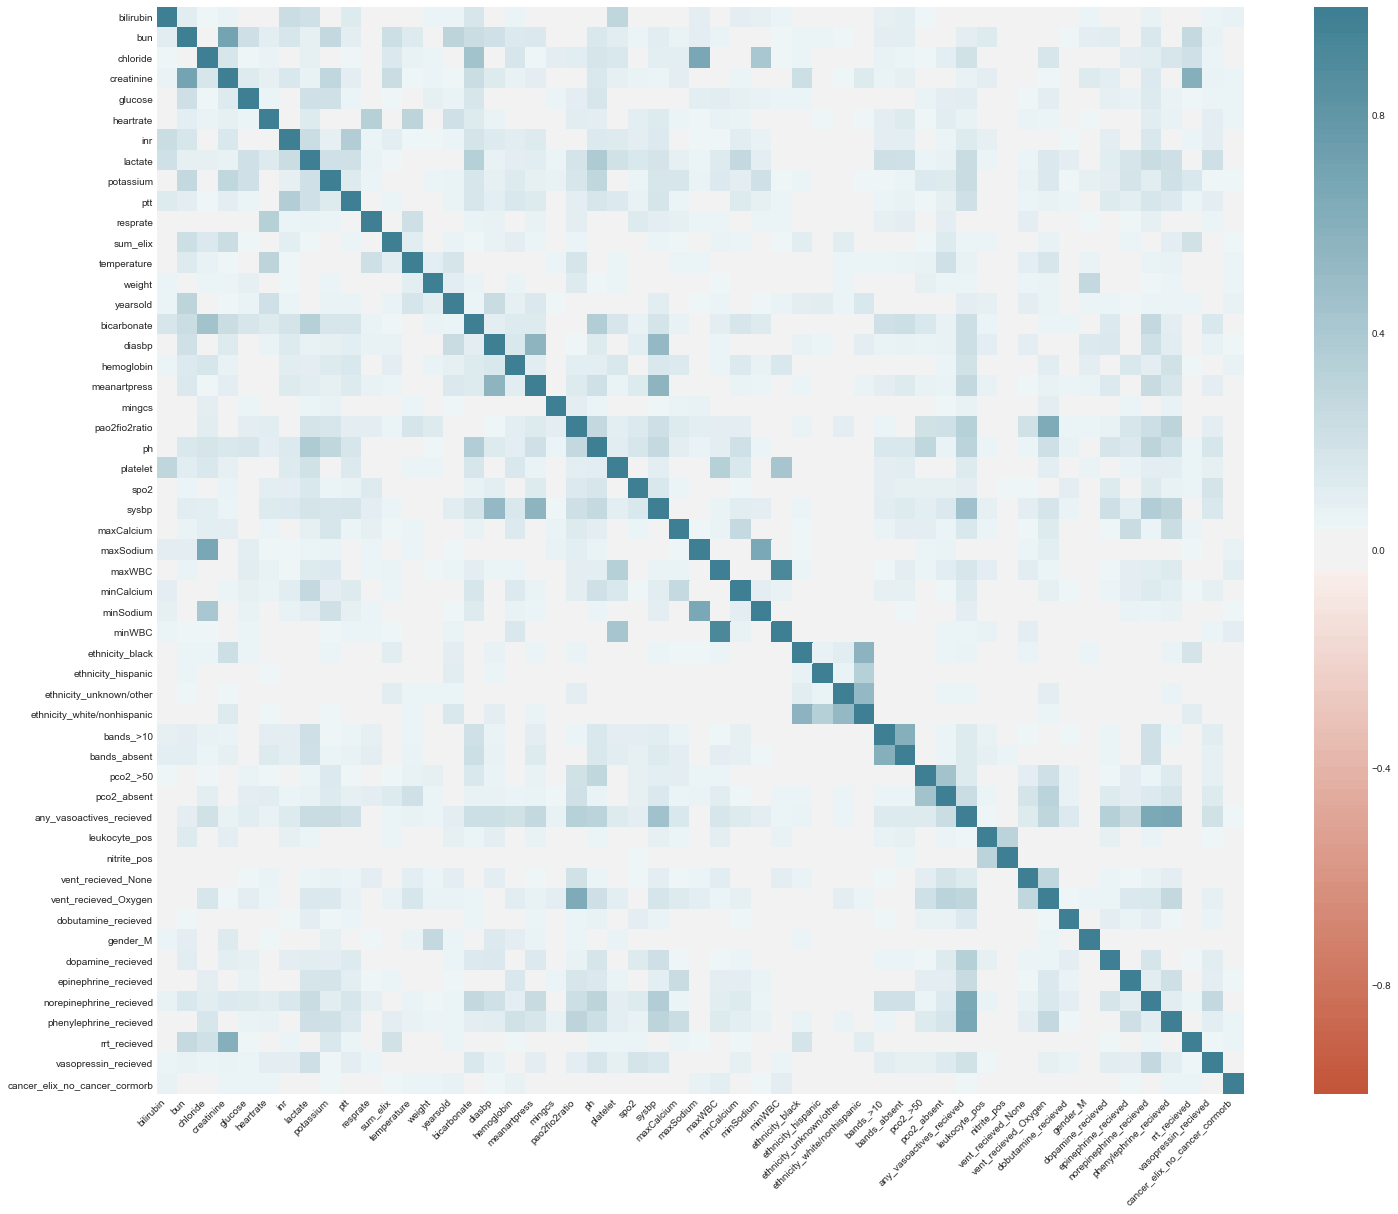

time: 1.79 s


In [42]:
corr = x_train.corr().abs()

plt.figure(figsize=(25, 20))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [43]:
sol = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))
cor_df=pd.DataFrame(sol)#.sort_values(kind="quicksort") #[-10:0])
cor_df=cor_df.reset_index()
cor_df=cor_df.rename(columns={'level_0': 'corx', 'level_1': 'cory', 0:'corr'})
cor_df2=cor_df[(cor_df['corx']!=cor_df['cory']) & (cor_df['corr']>0.7)].sort_values('corr', ascending=False)
cor_df2.head()

,corx,cory,corr
0,maxWBC,minWBC,0.91524


time: 15.1 ms


### DROPING one of the 2 columns with correlation >0.7  (depreciated)

In [44]:
# x_train.drop(columns=list(cor_df2['corx']), inplace=True, errors='raise')
# x_test.drop(columns=list(cor_df2['corx']), inplace=True, errors='raise')

time: 264 µs


### formatting x and y for modleing

In [45]:
x=np.array(x_train.copy())
y=y_train.copy() #copy of y_train
y=y.astype('int')
#time_interval=4

time: 5.03 ms


In [46]:
print(len(x_train),len(x_test))

7205 3100
time: 826 µs


In [47]:
y_train

array([0, 0, 1, ..., 0, 0, 0])

time: 2.31 ms


In [48]:
len(list(x_train))

53

time: 2 ms


In [49]:
def save_df(df, df_name='default', rel_path='/data/final/'):
    """
    simple function for saving result table. uses the date and supplied df name and saves to the savepath specified above.
    """
    global folder
    
    save_path= str(repository_path)+rel_path
    
    address=save_path+'{}_{}/'.format(date,folder)
    if not os.path.exists(address):
        print(address)
        os.makedirs(address)
    else:
        print(address)
        
    if address.endswith('/')==False:
        address= address+'/'
        
    if df_name == 'default':
        df_name =[x for x in globals() if globals()[x] is df][0]
        
    pd.DataFrame(df).to_csv(Path(address+'{}_{}.csv'.format(date, df_name)))


time: 1.64 ms


In [53]:
# if save_boolean==True:
#     save_df(x_train, 'x_train_final', rel_path='/data/final/')
#     save_df(x_test, 'x_test_final', rel_path='/data/final/')
#     save_df(y_train, 'y_train_final', rel_path='/data/final/')
#     save_df(y_test, 'y_test_final', rel_path='/data/final/')
#     save_df(z_icustay_id, 'icustay_train', rel_path='/data/final/') #just added, need to rerun all models. 12-19-19
#     save_df(z_icustay_id_test, 'icustay_test', rel_path='/data/final/')


/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/final/16122019_24_hr_window_morecases/
/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/final/16122019_24_hr_window_morecases/
/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/final/16122019_24_hr_window_morecases/
/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/final/16122019_24_hr_window_morecases/
/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/final/16122019_24_hr_window_morecases/
/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/final/16122019_24_hr_window_morecases/
time: 937 ms


# Modelbuilding
## test entire trainset and predict trainset.
* step1) hypertune and evaluate models on 10fold cv.  
* step2) test entire train set and predict testset.
* step3) generate figures

In [50]:
from parameters import nfolds, scoring, n_iter, gridsearch
##defaults
# nfolds=10
# scoring='roc_auc'
# n_iter=20 #for gridsearch
# gridsearch=False #gridsearch=False means it does triaged hyperparameter combinations based on some algorithm. True= tests all 


time: 571 µs


In [51]:
def evaluate(model, x, y):
    "simple classification evaluation metrics and output used in my hypertuning functions"
    from sklearn.metrics import log_loss
    
    y_hat = model.predict(x)
    y_hat_proba = model.predict_proba(x)[:, 1] 
    errors = abs(y_hat - y)
    mape = 100 * np.mean(errors / y)
    accuracy = 100 - mape
    auc=roc_auc_score(y, y_hat_proba)
    loss= log_loss(y, y_hat_proba)
        
    print ('the AUC is: {:0.3f}'.format(auc))
    print ('the logloss is: {:0.3f}'.format(loss))
    print(confusion_matrix(y, y_hat))
    print(classification_report(y,y_hat, digits=3))
    
    if scoring=='neg_log_loss':
        return_value=loss
    elif scoring=='roc_auc':
        return_value=auc
    else:
        raise ValueError
    
    return (return_value)



time: 1.98 ms


In [52]:
def hypertuning_fxn(X, y, nfolds, model , param_grid, scoring=scoring, gridsearch=True, n_iter=20, verbose=False): 
    from sklearn.model_selection import GroupKFold

    np.random.seed(12345)
    if gridsearch==True:
        grid_search = GridSearchCV(estimator= model,
                                         param_grid=param_grid,
                                         cv=GroupKFold(nfolds),
                                         scoring=scoring,
                                         return_train_score=True,
                                         n_jobs = -1)
    else:
        grid_search = RandomizedSearchCV(estimator= model,
                                         param_distributions= param_grid,
                                         n_iter=n_iter,
                                         cv=GroupKFold(nfolds),
                                         scoring=scoring,
                                         return_train_score=True,
                                         random_state=12345,
                                         n_jobs = -1)
        
    grid_search.fit(X, y, groups=z_subject_id)    
    print(" scorer function: {}".format(scoring))
    print(" ##### CV performance: mean & sd scores #####")

    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    print('best cv score: {:0.3f}'.format(grid_search.best_score_))
    print('best cv params: ', grid_search.best_params_)

    worst_index=np.argmin(grid_search.cv_results_['mean_test_score'])
    print('worst cv score: {:0.3f}'.format(grid_search.cv_results_['mean_test_score'][worst_index]))
    print('worst cv params: ', grid_search.cv_results_['params'][worst_index])
    ##
    if verbose==True:
        for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))

    print('##### training set performance #####\n')   
    print(' best hypertuned model training set performance:')
    best_random = grid_search.best_estimator_
    best_random_auc = evaluate(best_random, x, y)
    
    print(' worst hypertuned model training set performance:')
    worst_params= grid_search.cv_results_['params'][worst_index]
    worst_random=model.set_params(**worst_params)
    worst_random.fit(x,y)
    worst_random_auc = evaluate(worst_random, x, y)      
          
    print('relative scorer change of {:0.2f}%. between worst and best hyperparams on TRAINING set (may be overfit)'.format( 100 * (best_random_auc - worst_random_auc) / worst_random_auc))
    
    return(grid_search)

time: 3.76 ms


In [53]:
def hypertuned_cv_fxn(x, y, model_in, nfolds):
    """
    the goal of this function is to take the best hypertuned model and 
    generate average and std for F-1, precision, recall, npv, and AUC across each fold.
    Ideally i could have generated this above in my hypertuning cv function,
    but it actually took less computational time to just rerun cv on the best performing evaluator and collect all of the averaged performance metrics
    """
    
    from sklearn.model_selection import GroupKFold
    import sklearn.metrics as metrics
    from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score
    from sklearn.base import clone
    
    pos_label=1
    model= clone(model_in, safe=True)
    np.random.seed(12345)
    group_kfold = GroupKFold(n_splits=nfolds)
    group_kfold.get_n_splits(x, y, z_subject_id)

    f1_y_cv=[]
    auc_y_cv=[]
    prec_y_cv=[]
    recall_y_cv=[]
    npv_y_cv=[]

    for train_index, test_index in group_kfold.split(x, y, z_subject_id):
        x_train_cv, x_test_cv = x[train_index], x[test_index]
        y_train_cv, y_test_cv = y[train_index], y[test_index]
        model.fit(x_train_cv, y_train_cv)
        
        y_proba = model.predict_proba(x_test_cv)[:,1]
        y_pred = model.predict(x_test_cv)

        fpr, tpr, thresholds = metrics.roc_curve(y_test_cv, y_proba, pos_label=pos_label)    
        #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden. idx is needed in the roc
        youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds,tp90=True)
        y_pred_youden = [1 if y >= youden_threshold else 0 for y in y_proba]
            
        npv_y=confusion_matrix(y_test_cv, y_pred_youden)[0,0]/sum(np.array(y_pred_youden)==0)
        npv_y_cv.append(npv_y)

        prec_y= precision_score(y_true=y_test_cv, y_pred= y_pred_youden, pos_label=pos_label)
        prec_y_cv.append(prec_y)

        recall_y= recall_score(y_true=y_test_cv, y_pred= y_pred_youden, pos_label=pos_label)
        recall_y_cv.append(recall_y)

        f1_y= f1_score(y_true=y_test_cv, y_pred= y_pred_youden, pos_label=pos_label)
        f1_y_cv.append(f1_y)

        ###need to debug this.###
        auc_y=roc_auc_score(y_true=y_test_cv, y_score= y_proba)
        auc_y_cv.append(auc_y)
        
        youden_dic_cv= {'model':type(model).__name__, 
                'auc':np.mean(auc_y_cv),
                'auc_sd':np.std(auc_y_cv),
                'precision':np.mean(prec_y_cv),
                'precision_sd':np.std(prec_y_cv),
                'recall':np.mean(recall_y_cv),
                'recall_sd':np.std(recall_y_cv),
                'f1':np.mean(f1_y_cv),
                'f1_sd':np.std(f1_y_cv),
                'npv':np.mean(npv_y_cv),
                'npv_sd':np.std(npv_y_cv)}
        
    return(youden_dic_cv)

time: 5.32 ms


## youden index and plotting functions

In [54]:
def saveplot(plt, figure_name):
    """
    simple function for saving plots
    """
    address = str(repository_path)+'/figures/{}_{}'.format(date,folder)
    print(address)

    if not os.path.exists(address):
        os.makedirs(address)
    plt.savefig(address+"/{}.png".format(figure_name),bbox_inches='tight')

def optimal_youden_index(fpr, tpr, thresholds, tp90=True):
    """
    inputs fpr, tpr, thresholds from metrics.roc(),
    outputs the clasification threshold, roc dataframe, and the index of roc dataframe for optimal youden index
    """
    #making dataframe out of the thresholds
    roc_df= pd.DataFrame({"thresholds": thresholds,"fpr":fpr, "tpr": tpr})
    roc_df.iloc[0,0] =1
    roc_df['yuden']= roc_df['tpr']-roc_df['fpr']
    
    if tp90==True:
        idx= roc_df[roc_df['tpr']>=0.9]['yuden'].idxmax() #changed this so now finds optimial yuden threshold but tp>=90%
    else:
        idx=roc_df['yuden'].idxmax() #MAX INDEX
    
    youden_threshold=roc_df.iloc[idx,0] #threshold for max youden
    return(youden_threshold, roc_df, idx)
    
def plot_roc(fpr, tpr, roc_auc, roc_df, idx, save=save_boolean,model_name=None, folder_name=None, file_name=None):
    plt.title('ROC with optimal Youden Index')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    
    #finding the point on the line given threshold 0.5 (finding closest row in roc_df)
    og_idx=roc_df.iloc[(roc_df['thresholds']-0.5).abs().argsort()[:1]].index[0]
    plt.plot(roc_df.iloc[og_idx,1], roc_df.iloc[og_idx,2],marker='o', markersize=5, color="g")
    plt.annotate(s="P(>=0.5)",xy=(roc_df.iloc[og_idx,1]+0.02, roc_df.iloc[og_idx,2]-0.04),color='g') #textcoords
    
    plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=5, color="r") ##
    plt.annotate(s="TPR>=0.9",xy=(roc_df.iloc[idx,1]+0.02, roc_df.iloc[idx,2]-0.04),color='r' ) #textcoords
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(color='grey', linestyle='-', linewidth=1, alpha=0.2)
    
    if save==True:
        saveplot(plt, figure_name="{}_roc".format(model_name))
    else: pass
    
    plt.show()
    

time: 4.15 ms


In [55]:
def classifier_eval(model, x=x, y=y, proba_input=False,pos_label=1, print_default=True,model_name=None, folder_name=None, save=save_boolean):
    import sklearn.metrics as metrics
    from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score
    """
    classification evaluation function. able to print/save the following:
    
    print/save the following:
        ROC curve marked with threshold for optimal youden (maximizing tpr+fpr with constraint that tpr>0.9)

        using 0.5 threshold:
            confusion matrix
            classification report
            npv
            accuracy

        using optimal youden (maximizing tpr+fpr with constraint that tpr>0.9):
            confusion matrix
            classification report
            npv
            accuracy
    
    output: 
        outputs modelname, auc, precision, recall, f1, and npv to a dictionary. 
    
    notes:
    youden's J statistic:
    J= sensitivity + specificity -1
    (truepos/ truepos+falseneg) + (true neg/ trueneg + falsepos) -1. 
    NOTE: with tpr>0.9 turned on, the youden statistic is basically just the furthest point on the line away from the midline with tpr>=0.9
    NOTE2: this function arguably does too much. in the future it may be better to seperate it out into more compartmental functions like with preprocessing().
    """
    
    if proba_input==True: 
        y_proba= model
        y_pred=[1 if y >= 0.5 else 0 for y in y_proba]
    
    else:
        model_name=type(model).__name__

        y_pred = model.predict(x)
        y_proba = model.predict_proba(x)[:,1]
        
    fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)
#     print("AUROC:",roc_auc)
    
    #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden. idx is needed in the roc
    youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds,tp90=True)

    #plotting roc
    plot_roc(fpr, tpr, roc_auc, roc_df, idx, save=save, model_name=model_name,folder_name=folder)
    plt.show(), plt.close()
    
    #printing npv, recall, precision, accuracy
    npv=confusion_matrix(y, y_pred)[0,0]/sum(np.array(y_pred)==0)
    prec= precision_score(y_true=y, y_pred= y_pred, pos_label=pos_label)
    recall= recall_score(y_true=y, y_pred= y_pred, pos_label=pos_label)
    f1= f1_score(y_true=y, y_pred= y_pred, pos_label=pos_label)
    
    if print_default==True: ###can opt to not print the 0.5 classification threshold classification report/conf matrix
        #plotting confusion matrixs
        print("\n******* Using 0.5 Classification Threshold *******\n")
        print(confusion_matrix(y, y_pred))
        print ('the Accuracy is: {:01.3f}'.format(accuracy_score(y, y_pred)))
        print ("npv: {:01.3f}".format(npv))
        print ('the classification_report:\n', classification_report(y,y_pred, digits=3))
    else:
        pass
    
    #### YOUDEN ADJUSTMENT #####

    print("\n******* Using Optimal Youden Classification Threshold *******\n")
    print("\nthe Youden optimal index is : {:01.3f}".format(youden_threshold))

    y_pred_youden = [1 if y >= youden_threshold else 0 for y in y_proba]

    npv_y=confusion_matrix(y, y_pred_youden)[0,0]/sum(np.array(y_pred_youden)==0)
    prec_y= precision_score(y_true=y, y_pred= y_pred_youden, pos_label=pos_label)
    recall_y= recall_score(y_true=y, y_pred= y_pred_youden, pos_label=pos_label)
    f1_y= f1_score(y_true=y, y_pred= y_pred_youden, pos_label=pos_label)
    auc_y=roc_auc_score(y_true=y, y_score= y_proba)
    
    ##plotting and saving confusion matrix
    confusion_youden=confusion_matrix(y, y_pred_youden)
    
    #plotting confusion matrixs
    print(confusion_matrix(y, y_pred_youden))
    print ('the Accuracy is: {:01.3f}'.format(accuracy_score(y, y_pred_youden)))
    print ("npv: {:01.3f}".format(npv_y))
    print ('the classification_report:\n', classification_report(y,y_pred_youden, digits=3))
    
    youden_dic= {'model':model_name, 'auc':auc_y, 'precision':prec_y, 'recall':recall_y, 'f1':f1_y, 'npv':npv_y}
    return(youden_dic)
    

time: 5.63 ms


## step1) hypertuning and cv
* xgboost
* randomforest
* support vector classifier
* logistic regression (l1 and l2)
* k-nearest neighbors

#### xgboost hypertune

In [57]:
z_subject_id

0       28448
1        9514
2       56369
3        9960
4       25225
        ...  
7200    31011
7201    42148
7202    31252
7203    42919
7204    14330
Name: subject_id, Length: 7205, dtype: int64

time: 6.63 ms


In [56]:
###xgboost
model= XGBClassifier(n_estimators=100, min_child_weight=2, #changed: GridSearchCV ->RandomizedSearchCV
                                              gamma=0, subsample=0.8, colsample_bytree=0.8,
                                              objective='binary:logistic', n_jobs=-1, seed=27)
scale_pos_weight = [1, 5, 10] #0.1
max_depth = [1, 2, 3, 4, 5]
learning_rate=[0.01, 0.1, 0.5, 1]
param_grid = {'scale_pos_weight': scale_pos_weight, 'max_depth' : max_depth, "learning_rate":learning_rate}
xgboost_hyper=hypertuning_fxn(x, y, nfolds=nfolds, model=model , param_grid=param_grid, scoring=scoring, n_iter=n_iter, gridsearch=gridsearch)

 scorer function: roc_auc
 ##### CV performance: mean & sd scores #####
best cv score: 0.792
best cv params:  {'scale_pos_weight': 1, 'max_depth': 3, 'learning_rate': 0.1}
worst cv score: 0.702
worst cv params:  {'scale_pos_weight': 10, 'max_depth': 3, 'learning_rate': 1}
##### training set performance #####

 best hypertuned model training set performance:
the AUC is: 0.858
the logloss is: 0.385
[[5363  149]
 [1050  643]]
              precision    recall  f1-score   support

           0      0.836     0.973     0.899      5512
           1      0.812     0.380     0.518      1693

   micro avg      0.834     0.834     0.834      7205
   macro avg      0.824     0.676     0.708      7205
weighted avg      0.831     0.834     0.810      7205

 worst hypertuned model training set performance:
the AUC is: 0.953
the logloss is: nan
[[4196 1316]
 [  20 1673]]
              precision    recall  f1-score   support

           0      0.995     0.761     0.863      5512
           1      0.56

In [59]:
y

array([0, 0, 1, ..., 0, 0, 0])

time: 1.94 ms


In [61]:
y.size

8501

time: 2.49 ms


In [62]:
sum(y)

1688

time: 13.7 ms


In [63]:
xgboost_cv= hypertuned_cv_fxn(x, y, xgboost_hyper.best_estimator_, nfolds=nfolds)

time: 5.43 s


In [64]:
xgboost_cv

{'auc': 0.778611869743125,
 'auc_sd': 0.011600021627426748,
 'f1': 0.421846655002753,
 'f1_sd': 0.029097234102649666,
 'model': 'XGBClassifier',
 'npv': 0.9465304999245527,
 'npv_sd': 0.009880858248002751,
 'precision': 0.2750150000954094,
 'precision_sd': 0.02456001985232659,
 'recall': 0.9104317799012019,
 'recall_sd': 0.009550864885944919}

time: 3.18 ms


#### RF hypertune

In [65]:
###rf
#{'bootstrap': False, 'class_weight': None, 'max_depth': 25, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200} 
# Number of trees in random forest
n_estimators = [10,15, 25, 50, 150, 250] #[int(x) for x in np.linspace(start = 10, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = [3,10,20,'auto']
# Maximum number of levels in tree
max_depth = [5,10, 25]#[int(x) for x in np.linspace(5, 110, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 5, 10]
# Method of selecting samples for training each tree. supposedly better with false when classes aren't perfectly ballanced
bootstrap = [True, False] #[True, False] #[False] 
#### note about bootstrap= off
###Without bootstrapping, all of the data is used to fit the model, so there is not random variation between trees with respect to the selected examples at each stage. 
###However, random forest has a second source of variation, which is the random subset of features to try at each split.
### The documentation states "The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default)," 
### which implies that bootstrap=False draws a sample of size equal to the number of training examples without replacement, i.e. the same training set is always used.
### we test this turned off because with unballanced classes turning this off can sometimes improve performance

#class_weight is either a dictionary of each class to a uniform weight for that class (e.g., {1:.9, 2:.5, 3:.01}), or is a string telling sklearn how to automatically determine this dictionary.
class_weight= [None, {0:(1/np.bincount(y))[0], 1:(1/np.bincount(y))[1]}]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'class_weight': class_weight,
               'bootstrap': bootstrap}

model= RandomForestClassifier(criterion='entropy', random_state=12345)

#rf_hyper=hypertuning_fxn(x, y, nfolds=nfolds, model=model , param_grid=param_grid, scoring=scoring,n_iter = n_iter, gridsearch=False)
rf_hyper=hypertuning_fxn(x, y, nfolds=nfolds, model=model , param_grid=param_grid, scoring=scoring,n_iter = n_iter, gridsearch=False)

 scorer function: roc_auc
 ##### CV performance: mean & sd scores #####
best cv score: 0.779
best cv params:  {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 25, 'class_weight': None, 'bootstrap': False}
worst cv score: 0.727
worst cv params:  {'n_estimators': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 10, 'max_depth': 25, 'class_weight': None, 'bootstrap': True}
##### training set performance #####

 best hypertuned model training set performance:
the AUC is: 1.000
the logloss is: 0.156
[[6812    1]
 [ 122 1566]]
              precision    recall  f1-score   support

           0      0.982     1.000     0.991      6813
           1      0.999     0.928     0.962      1688

   micro avg      0.986     0.986     0.986      8501
   macro avg      0.991     0.964     0.977      8501
weighted avg      0.986     0.986     0.985      8501

 worst hypertuned model training set performance:
the AUC is: 0.998
the

In [66]:
y

array([0, 0, 0, ..., 0, 0, 0])

time: 2 ms


In [67]:
# best cv score: 0.791
# best cv params:  {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 3, 'max_depth': 25, 'class_weight': {0: 0.000181422351233672, 1: 0.0005906674542232723}, 'bootstrap': False}
    
# #changing from niter=40 and bootstrap t/f:
# best cv score: 0.788
# best cv params:  {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10, 'class_weight': None, 'bootstrap': True}


time: 1.26 ms


In [68]:
rf_cv= hypertuned_cv_fxn(x, y, rf_hyper.best_estimator_, nfolds=nfolds)

time: 34.9 s


#### SVC hypertune

In [69]:
model= svm.SVC(probability=True)
kernel = ['linear']#, 'rbf','poly']
#gamma = [0.1, 1, 'auto'] #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. default=’auto’ uses 1 / n_features
C = [0.1, 1, 10, 100] #Penalty parameter C of the error term.
degree = [1,2]
class_weight=['balanced', None]

param_grid = {'kernel': kernel,
              #'gamma': gamma,
              'C': C,
              'degree': degree,
              'class_weight':class_weight}

svc_hyper=hypertuning_fxn(x, y, nfolds=nfolds, model=model , param_grid=param_grid,scoring=scoring, n_iter=5, gridsearch=False)
#svc_hyper=hypertuning_fxn(x, y, nfolds=4, model=model , param_grid=param_grid, base_model= base_model, scoring="neg_log_loss", n_iter=10, gridsearch=False)

 scorer function: roc_auc
 ##### CV performance: mean & sd scores #####
best cv score: 0.765
best cv params:  {'kernel': 'linear', 'degree': 1, 'class_weight': 'balanced', 'C': 10}
worst cv score: 0.721
worst cv params:  {'kernel': 'linear', 'degree': 2, 'class_weight': None, 'C': 10}
##### training set performance #####

 best hypertuned model training set performance:
the AUC is: 0.778
the logloss is: 0.416
[[5151 1662]
 [ 584 1104]]
              precision    recall  f1-score   support

           0      0.898     0.756     0.821      6813
           1      0.399     0.654     0.496      1688

   micro avg      0.736     0.736     0.736      8501
   macro avg      0.649     0.705     0.658      8501
weighted avg      0.799     0.736     0.756      8501

 worst hypertuned model training set performance:
the AUC is: 0.717
the logloss is: 0.478
[[6689  124]
 [1469  219]]
              precision    recall  f1-score   support

           0      0.820     0.982     0.894      6813
       

In [70]:
svc_cv= hypertuned_cv_fxn(x, y, svc_hyper.best_estimator_, nfolds=10)

time: 5min 40s


### logistic regression hypertune

In [72]:
###logreg
model= LogisticRegression(random_state=12345)
#model = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True, intercept_scaling=1, class_weight='balanced', random_state=None)

penalty = ['l1','l2']
class_weight=['balanced',None]

param_grid = {'penalty': penalty,
              'class_weight': class_weight}

logreg_hyper=hypertuning_fxn(x, y, nfolds=nfolds, model=model , param_grid=param_grid, scoring=scoring, n_iter=n_iter, gridsearch=True)

 scorer function: roc_auc
 ##### CV performance: mean & sd scores #####
best cv score: 0.767
best cv params:  {'class_weight': 'balanced', 'penalty': 'l1'}
worst cv score: 0.763
worst cv params:  {'class_weight': None, 'penalty': 'l2'}
##### training set performance #####

 best hypertuned model training set performance:
the AUC is: 0.776
the logloss is: 0.566
[[5074 1739]
 [ 555 1133]]
              precision    recall  f1-score   support

           0      0.901     0.745     0.816      6813
           1      0.394     0.671     0.497      1688

   micro avg      0.730     0.730     0.730      8501
   macro avg      0.648     0.708     0.656      8501
weighted avg      0.801     0.730     0.752      8501

 worst hypertuned model training set performance:
the AUC is: 0.772
the logloss is: 0.416
[[6622  191]
 [1310  378]]
              precision    recall  f1-score   support

           0      0.835     0.972     0.898      6813
           1      0.664     0.224     0.335      1688

  

In [73]:
logreg_cv= hypertuned_cv_fxn(x, y, logreg_hyper.best_estimator_, nfolds=10)

time: 2.09 s


### KNN hypertune

In [74]:

from sklearn.neighbors import KNeighborsClassifier
model= KNeighborsClassifier()

n_neighbors = [3,4,5, 8, 10, 25]
weights=['uniform']
p=[1,2] #1= mmanhattan, 2= euclidian


param_grid = {'n_neighbors': n_neighbors,
              'weights': weights,
              'p': p}

knn_hyper=hypertuning_fxn(x, y, nfolds=nfolds, model=model , param_grid=param_grid, scoring=scoring, n_iter=n_iter, gridsearch=True)

 scorer function: roc_auc
 ##### CV performance: mean & sd scores #####
best cv score: 0.708
best cv params:  {'n_neighbors': 25, 'p': 1, 'weights': 'uniform'}
worst cv score: 0.621
worst cv params:  {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
##### training set performance #####

 best hypertuned model training set performance:
the AUC is: 0.796
the logloss is: 0.411
[[6781   32]
 [1539  149]]
              precision    recall  f1-score   support

           0      0.815     0.995     0.896      6813
           1      0.823     0.088     0.159      1688

   micro avg      0.815     0.815     0.815      8501
   macro avg      0.819     0.542     0.528      8501
weighted avg      0.817     0.815     0.750      8501

 worst hypertuned model training set performance:
the AUC is: 0.919
the logloss is: 0.245
[[6644  169]
 [ 962  726]]
              precision    recall  f1-score   support

           0      0.874     0.975     0.922      6813
           1      0.811     0.430     0.562 

In [75]:
knn_cv= hypertuned_cv_fxn(x, y, knn_hyper.best_estimator_, nfolds=10)

time: 8.8 s


### Multilayer Perceptron (MLP) hypertune

In [76]:
### MLP w/ standard scalar and early stopping (improved cv performance)

from sklearn.preprocessing import StandardScaler  # doctest: +SKIP
# scaler = StandardScaler()  # doctest: +SKIP
# scaler.fit(x)  # doctest: +SKIP
# x_scalar = scaler.transform(x)  # doctest: +SKIP

from sklearn.neural_network import MLPClassifier
#hidden_layer_sizes = [(50,), (100,), (150,), (250,)] #origional used parameters #(50,50), (100,100), (150,150),(300,)

hidden_layer_sizes =[(50), (50,50), (50,50,50), (50,100,50), (100,),(150)]
solver= ['sgd', 'adam']
#     'alpha': [0.0001, 0.05],
#     'learning_rate': ['constant','adaptive'],

activation= ['relu','tanh']#, 'logistic']

alpha= [0.001, 0.05] #L2 penalization degree #[0.001, 0.01]

learning_rate= ['adaptive']
learning_rate_init= [0.001, 0.01]

param_grid = {'hidden_layer_sizes': hidden_layer_sizes, 
              'solver':solver,
              'activation':activation,
              'alpha': alpha,
              'learning_rate': learning_rate,
              'learning_rate_init': learning_rate_init
             }

model= MLPClassifier(early_stopping=True, random_state=12345)

#removed teh x_scalar
mlp_hyper=hypertuning_fxn(x, y, nfolds=nfolds, model=model , param_grid=param_grid, scoring=scoring,n_iter = 80, gridsearch=True) #gridsearch=False: testing with smaller, randomized grid
#gridsearch=False: testing with smaller, randomized grid. went from ~30 sec to 13min when ==True
# adding in solver: sgd and adam 1.5min ->8min

 scorer function: roc_auc
 ##### CV performance: mean & sd scores #####
best cv score: 0.767
best cv params:  {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': 150, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'solver': 'adam'}
worst cv score: 0.516
worst cv params:  {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'solver': 'sgd'}
##### training set performance #####

 best hypertuned model training set performance:
the AUC is: 0.765
the logloss is: 0.426
[[6482  331]
 [1221  467]]
              precision    recall  f1-score   support

           0      0.841     0.951     0.893      6813
           1      0.585     0.277     0.376      1688

   micro avg      0.817     0.817     0.817      8501
   macro avg      0.713     0.614     0.634      8501
weighted avg      0.791     0.817     0.790      8501

 worst hypertuned model training set performance:
the AUC is: 0.519
the loglo

In [77]:
mlp_cv= hypertuned_cv_fxn(x, y, mlp_hyper.best_estimator_, nfolds=10)


time: 6.84 s


## idea: Rashamon effect: does ensembling models improve prediction performance?
the ensemble is intresting if the ensemble predicts a different group of patients (or has different variable importance).

rashamon effect where we don't gain from ensemble: identifying same patints in different ways
rashamon effect where we do gain from ensemble: identifying DIFFERENT patients in the different ways

In [78]:
# to test this, i first need to instantiate my other models, then ensemble them together. 

time: 764 µs


In [79]:
def reset_model(model_name, hardcode=False):
    global xgboost_hyper, logreg_hyper, rf_hyper, knn_hyper, mlp_hyper, svc_hyper
    
    if model_name== 'xgboost':
        model = xgboost_hyper.best_estimator_

    elif model_name== 'logreg':
        model = logreg_hyper.best_estimator_

    elif model_name== 'rf': 
        model = rf_hyper.best_estimator_

    elif model_name== 'svc':
        model = svc_hyper.best_estimator_

    elif model_name== 'knn':
        model = knn_hyper.best_estimator_
        
    elif model_name== 'mlp':
        model = mlp_hyper.best_estimator_
        
    return(model)

time: 21.5 ms


# test entire trainset and predict testset.
*<del> step1) hypertune xgb via 10fold cv.
* step2) test entire trainset and predict testset.
* step3) generate figures

In [80]:
def get_auc_score(model,train_index, x=x,y=y):
    y_pred_proba = model.predict_proba(x[train_index])[:, 1] 
    roc_score=roc_auc_score(y[train_index], y_pred_proba)
    return(roc_score)

time: 4.19 ms


# Ensemble CV and testing models

## test entire trainset and predict trainset.
<del> * step1) hypertune xgb on 10fold cv.
    
<del> * step2) test entire train set and predict testset.
* step3) generate figures


In [81]:
#setting up test table
test_summary_df= pd.DataFrame({'model':[],'auc':[], 'precision':[], 'recall':[], 'f1':[], 'npv':[]})
test_summary_df

,model,auc,precision,recall,f1,npv


time: 8.74 ms


### model fitting

In [82]:
xgboost = reset_model('xgboost')
xgboost.fit(x, y)

logreg = reset_model('logreg')
logreg.fit(x, y)

rf= reset_model('rf')
rf.fit(x,y)

svc= reset_model('svc')
svc.fit(x, y)

knn= reset_model('knn')
knn.fit(x,y)

mlp= reset_model('mlp')
mlp.fit(x,y)

from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators=[("xgboost", xgboost), ('rf', rf), ('log_reg', logreg), ('mlp',mlp), ('svc',svc)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='soft', n_jobs=-1)
ensemble.fit(x,y)
# If ‘hard’, uses predicted class labels for majority rule voting.
# Else if ‘soft’, predicts the class label based on the argmax of the sums of the predicted probabilities,
# which is recommended for an ensemble of well-calibrated classifiers.


# from sklearn.naive_bayes import GaussianNB
# gnb =GaussianNB()
# nb_y_pred = gnb.fit(x, y)


VotingClassifier(estimators=[('xgboost', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=2, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',...ar', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=-1, voting='soft', weights=None)

time: 1min 33s


### wrapping up ensemble and CV

In [83]:
#running the ensemble in cv
ensemble_cv= hypertuned_cv_fxn(x, y, ensemble, nfolds=nfolds)

time: 6min 1s


In [84]:
#updating the cv table with ensemble data
cv_summary_df= pd.DataFrame([rf_cv,
                             logreg_cv,
                             xgboost_cv,
                             svc_cv,
                             knn_cv,
                             mlp_cv,
                             ensemble_cv])
cv_summary_df= cv_summary_df.set_index('model').round(decimals=3).sort_values('auc', ascending=False)

if save_boolean==True:
    save_df(cv_summary_df, df_name='default', rel_path='/tables/')

cv_summary_df

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/tables/16122019_24_hr_window_morecases/


,auc,auc_sd,f1,f1_sd,npv,npv_sd,precision,precision_sd,recall,recall_sd
model,,,,,,,,,,
VotingClassifier,0.782,0.012,0.424,0.027,0.948,0.011,0.277,0.022,0.911,0.011
RandomForestClassifier,0.779,0.008,0.427,0.020,0.949,0.008,0.279,0.016,0.910,0.009
XGBClassifier,0.779,0.012,0.422,0.029,0.947,0.010,0.275,0.025,0.910,0.010
LogisticRegression,0.767,0.014,0.411,0.028,0.941,0.013,0.266,0.023,0.908,0.006
MLPClassifier,0.767,0.014,0.412,0.029,0.942,0.009,0.267,0.024,0.907,0.008
SVC,0.765,0.015,0.410,0.029,0.941,0.014,0.266,0.024,0.908,0.009
KNeighborsClassifier,0.708,0.010,0.355,0.022,0.937,0.018,0.218,0.017,0.958,0.027


time: 26.7 ms


## global model test set evaluation

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_24_hr_window_morecases


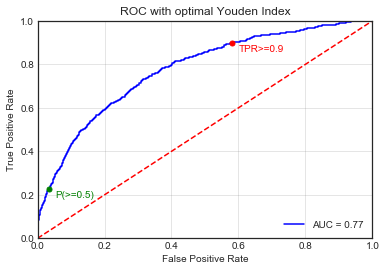


******* Using 0.5 Classification Threshold *******

[[2883   98]
 [ 582  168]]
the Accuracy is: 0.818
npv: 0.832
the classification_report:
               precision    recall  f1-score   support

           0      0.832     0.967     0.895      2981
           1      0.632     0.224     0.331       750

   micro avg      0.818     0.818     0.818      3731
   macro avg      0.732     0.596     0.613      3731
weighted avg      0.792     0.818     0.781      3731


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.113
[[1247 1734]
 [  75  675]]
the Accuracy is: 0.515
npv: 0.943
the classification_report:
               precision    recall  f1-score   support

           0      0.943     0.418     0.580      2981
           1      0.280     0.900     0.427       750

   micro avg      0.515     0.515     0.515      3731
   macro avg      0.612     0.659     0.503      3731
weighted avg      0.810     0.515     0.549      3731

time: 463 ms


In [85]:
xgboost_eval= classifier_eval(xgboost, x=np.array(x_test), y=y_test, model_name='xgboost', folder_name=folder)

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_24_hr_window_morecases


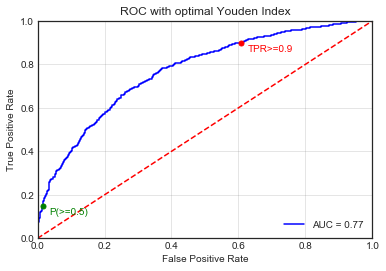


******* Using 0.5 Classification Threshold *******

[[2937   44]
 [ 639  111]]
the Accuracy is: 0.817
npv: 0.821
the classification_report:
               precision    recall  f1-score   support

           0      0.821     0.985     0.896      2981
           1      0.716     0.148     0.245       750

   micro avg      0.817     0.817     0.817      3731
   macro avg      0.769     0.567     0.571      3731
weighted avg      0.800     0.817     0.765      3731


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.121
[[1169 1812]
 [  75  675]]
the Accuracy is: 0.494
npv: 0.940
the classification_report:
               precision    recall  f1-score   support

           0      0.940     0.392     0.553      2981
           1      0.271     0.900     0.417       750

   micro avg      0.494     0.494     0.494      3731
   macro avg      0.606     0.646     0.485      3731
weighted avg      0.805     0.494     0.526      3731

time: 805 ms


In [86]:
rf_eval= classifier_eval(rf, x=np.array(x_test), y=y_test, model_name='rf', folder_name=folder)

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_24_hr_window_morecases


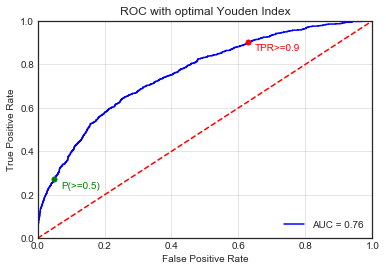


******* Using 0.5 Classification Threshold *******

[[2834  147]
 [ 548  202]]
the Accuracy is: 0.814
npv: 0.838
the classification_report:
               precision    recall  f1-score   support

           0      0.838     0.951     0.891      2981
           1      0.579     0.269     0.368       750

   micro avg      0.814     0.814     0.814      3731
   macro avg      0.708     0.610     0.629      3731
weighted avg      0.786     0.814     0.786      3731


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.138
[[1108 1873]
 [  74  676]]
the Accuracy is: 0.478
npv: 0.937
the classification_report:
               precision    recall  f1-score   support

           0      0.937     0.372     0.532      2981
           1      0.265     0.901     0.410       750

   micro avg      0.478     0.478     0.478      3731
   macro avg      0.601     0.637     0.471      3731
weighted avg      0.802     0.478     0.508      3731

time: 472 ms


In [87]:
mlp_eval= classifier_eval(mlp, x=np.array(x_test), y=y_test, model_name='mlp', folder_name=folder)

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_24_hr_window_morecases


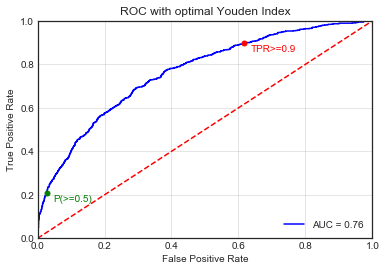


******* Using 0.5 Classification Threshold *******

[[2185  796]
 [ 265  485]]
the Accuracy is: 0.716
npv: 0.892
the classification_report:
               precision    recall  f1-score   support

           0      0.892     0.733     0.805      2981
           1      0.379     0.647     0.478       750

   micro avg      0.716     0.716     0.716      3731
   macro avg      0.635     0.690     0.641      3731
weighted avg      0.789     0.716     0.739      3731


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.107
[[1142 1839]
 [  75  675]]
the Accuracy is: 0.487
npv: 0.938
the classification_report:
               precision    recall  f1-score   support

           0      0.938     0.383     0.544      2981
           1      0.268     0.900     0.414       750

   micro avg      0.487     0.487     0.487      3731
   macro avg      0.603     0.642     0.479      3731
weighted avg      0.804     0.487     0.518      3731

time: 2 s


In [88]:
svc_eval= classifier_eval(svc, x=np.array(x_test), y=y_test, model_name='svc', folder_name=folder)

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_24_hr_window_morecases


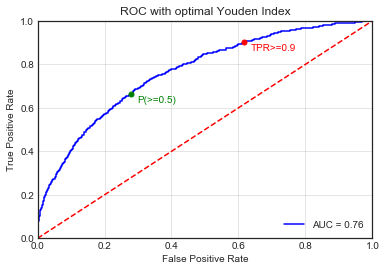


******* Using 0.5 Classification Threshold *******

[[2153  828]
 [ 252  498]]
the Accuracy is: 0.711
npv: 0.895
the classification_report:
               precision    recall  f1-score   support

           0      0.895     0.722     0.799      2981
           1      0.376     0.664     0.480       750

   micro avg      0.711     0.711     0.711      3731
   macro avg      0.635     0.693     0.640      3731
weighted avg      0.791     0.711     0.735      3731


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.311
[[1142 1839]
 [  73  677]]
the Accuracy is: 0.488
npv: 0.940
the classification_report:
               precision    recall  f1-score   support

           0      0.940     0.383     0.544      2981
           1      0.269     0.903     0.415       750

   micro avg      0.488     0.488     0.488      3731
   macro avg      0.604     0.643     0.479      3731
weighted avg      0.805     0.488     0.518      3731

time: 473 ms


In [89]:
# logreg_eval= classifier_eval(logreg, x=np.array(x_test), y=y_test)
logreg_eval= classifier_eval(logreg, x=np.array(x_test), y=y_test, model_name='logreg', folder_name=folder)

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_24_hr_window_morecases


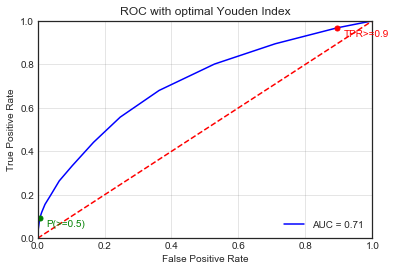


******* Using 0.5 Classification Threshold *******

[[2970   11]
 [ 705   45]]
the Accuracy is: 0.808
npv: 0.808
the classification_report:
               precision    recall  f1-score   support

           0      0.808     0.996     0.892      2981
           1      0.804     0.060     0.112       750

   micro avg      0.808     0.808     0.808      3731
   macro avg      0.806     0.528     0.502      3731
weighted avg      0.807     0.808     0.735      3731


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.040
[[ 313 2668]
 [  24  726]]
the Accuracy is: 0.278
npv: 0.929
the classification_report:
               precision    recall  f1-score   support

           0      0.929     0.105     0.189      2981
           1      0.214     0.968     0.350       750

   micro avg      0.278     0.278     0.278      3731
   macro avg      0.571     0.536     0.270      3731
weighted avg      0.785     0.278     0.221      3731

time: 5.55 s


In [90]:
knn_eval= classifier_eval(knn, x=np.array(x_test), y=y_test, model_name='knn', folder_name=folder)

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_24_hr_window_morecases


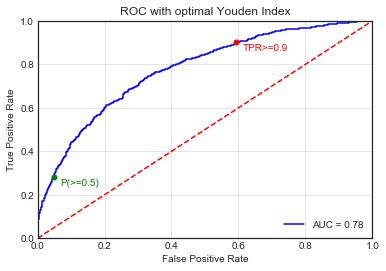


******* Using 0.5 Classification Threshold *******

[[2841  140]
 [ 538  212]]
the Accuracy is: 0.818
npv: 0.841
the classification_report:
               precision    recall  f1-score   support

           0      0.841     0.953     0.893      2981
           1      0.602     0.283     0.385       750

   micro avg      0.818     0.818     0.818      3731
   macro avg      0.722     0.618     0.639      3731
weighted avg      0.793     0.818     0.791      3731


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.167
[[1210 1771]
 [  74  676]]
the Accuracy is: 0.505
npv: 0.942
the classification_report:
               precision    recall  f1-score   support

           0      0.942     0.406     0.567      2981
           1      0.276     0.901     0.423       750

   micro avg      0.505     0.505     0.505      3731
   macro avg      0.609     0.654     0.495      3731
weighted avg      0.808     0.505     0.538      3731

time: 2.27 s


In [91]:
ensemble_eval= classifier_eval(ensemble, 
                               x=np.array(x_test),
                               y=y_test, 
                               model_name='ensemble',
                               folder_name=folder, save=True)

looks like its the rashamon effect that doesn't benefit from ensembling.

ie there are hidden variables that can discriminate the patients.

# classification performance table

In [92]:
test_summary_df= pd.DataFrame([xgboost_eval, rf_eval, logreg_eval,  mlp_eval, svc_eval, knn_eval, ensemble_eval])
test_summary_df=test_summary_df.set_index('model').round(decimals=3).sort_values('auc', ascending=False)
if save_boolean==True:
    save_df(test_summary_df, df_name='default', rel_path='/tables/')
print(test_summary_df)

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/tables/16122019_24_hr_window_morecases/
                          auc     f1    npv  precision  recall
model                                                         
VotingClassifier        0.776  0.423  0.942      0.276   0.901
XGBClassifier           0.775  0.427  0.943      0.280   0.900
RandomForestClassifier  0.770  0.417  0.940      0.271   0.900
LogisticRegression      0.765  0.415  0.940      0.269   0.903
SVC                     0.763  0.414  0.938      0.268   0.900
MLPClassifier           0.759  0.410  0.937      0.265   0.901
KNeighborsClassifier    0.711  0.350  0.929      0.214   0.968
time: 12.2 ms


# QC: checking performance on training set for xgboost and rf

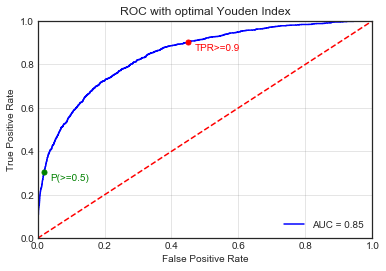


******* Using 0.5 Classification Threshold *******

[[6683  130]
 [1175  513]]
the Accuracy is: 0.846
npv: 0.850
the classification_report:
               precision    recall  f1-score   support

           0      0.850     0.981     0.911      6813
           1      0.798     0.304     0.440      1688

   micro avg      0.846     0.846     0.846      8501
   macro avg      0.824     0.642     0.676      8501
weighted avg      0.840     0.846     0.818      8501


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.127
[[3755 3058]
 [ 167 1521]]
the Accuracy is: 0.621
npv: 0.957
the classification_report:
               precision    recall  f1-score   support

           0      0.957     0.551     0.700      6813
           1      0.332     0.901     0.485      1688

   micro avg      0.621     0.621     0.621      8501
   macro avg      0.645     0.726     0.592      8501
weighted avg      0.833     0.621     0.657      8501

time: 435 ms


In [93]:
xgboost_train= classifier_eval(xgboost, x=np.array(x_train), y=y_train, model_name='xgboost_train', folder_name=folder, save=False)

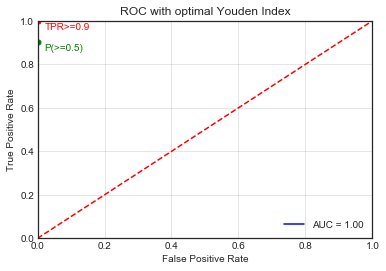


******* Using 0.5 Classification Threshold *******

[[6812    1]
 [ 122 1566]]
the Accuracy is: 0.986
npv: 0.982
the classification_report:
               precision    recall  f1-score   support

           0      0.982     1.000     0.991      6813
           1      0.999     0.928     0.962      1688

   micro avg      0.986     0.986     0.986      8501
   macro avg      0.991     0.964     0.977      8501
weighted avg      0.986     0.986     0.985      8501


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.347
[[6801   12]
 [   0 1688]]
the Accuracy is: 0.999
npv: 1.000
the classification_report:
               precision    recall  f1-score   support

           0      1.000     0.998     0.999      6813
           1      0.993     1.000     0.996      1688

   micro avg      0.999     0.999     0.999      8501
   macro avg      0.996     0.999     0.998      8501
weighted avg      0.999     0.999     0.999      8501

time: 772 ms


In [94]:
rf_train= classifier_eval(rf, x=np.array(x_train), y=y_train, model_name='rf_train', folder_name=folder, save=False)

# publication figures

In [95]:
# making a model dictionary for ease of use in plotting
keys= ['rf', 'xgboost', 'logreg', 'mlp','svc', 'knn', 'ensemble']
model_list=[rf, xgboost, logreg, mlp, svc, knn, ensemble]
models_dic={}
for i in range(0,len(model_list)):
    models_dic.update({keys[i] : model_list[i]} )

time: 3.2 ms


## stacked roc curve 

In [96]:
def roc_publishing(model, x, y, proba_input=False,pos_label=1, print_default=True, model_name=None):
    import sklearn.metrics as metrics
    from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score

    model_name=type(model).__name__

    y_proba = model.predict_proba(x)[:,1]
        
    fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)
    
    #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden. idx is needed in the roc
    youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds, tp90=True)
    
    return(fpr, tpr, roc_auc, roc_df, idx)

time: 11.1 ms


In [97]:
def stacked_roc(x_test, y_test, models_dic, first_bold=True):
    """
    plotting function to plot a stacked ROC based on models in a dictionary. 
    first_bold=True means that the first model in the dic will stand out and be a solid line, while others are dotted
    """
    
    global save_boolean
    
    plt.style.use('seaborn-white')
    plt.rcParams['figure.figsize'] = [7, 4]
    
    if first_bold==True: i=0
    else: i=1
        
#         #####
#     y_proba = model.predict_proba(x)[:,1]
        
#     fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
#     roc_auc = metrics.auc(fpr, tpr)
    
#     #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden. idx is needed in the roc
#     youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds,tp90=True)

#     #plotting roc
#     plot_roc(fpr, tpr, roc_auc, roc_df, idx, save=save, model_name=model_name,folder_name=folder)    
#         ######
        
    for model_name in models_dic.keys():
        #ax4= plt.plot(fpr, tpr, label = '%s AUC = %0.3f' % (model_name, roc_auc), linestyle='dotted')
        if i==0:
            model=models_dic[model_name]
            fpr, tpr, roc_auc, roc_df, idx= roc_publishing(model, x=np.array(x_test), y=y_test, model_name=model_name)
            print(model_name, roc_auc)
            ax1= plt.plot(fpr, tpr, 'b', label = '%s AUC = %0.3f' % (model_name, roc_auc), linewidth=2)
            og_idx=roc_df.iloc[(roc_df['thresholds']-0.5).abs().argsort()[:1]].index[0]
#             plt.plot(roc_df.iloc[og_idx,1], roc_df.iloc[og_idx,2],marker='o', markersize=8, color="black")
#             plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=6, color='r') ##
        
        else:
            model=models_dic[model_name]
            fpr, tpr, roc_auc, roc_df, idx= roc_publishing(model, x=np.array(x_test), y=y_test, model_name=model_name)
            print(model_name, roc_auc)
            ax1= plt.plot(fpr, tpr, label = '%s AUC = %0.3f' % (model_name, roc_auc), linestyle='dotted')
            og_idx=roc_df.iloc[(roc_df['thresholds']-0.5).abs().argsort()[:1]].index[0]
#             plt.plot(roc_df.iloc[og_idx,1], roc_df.iloc[og_idx,2],marker='o', markersize=8, color="black")
#             plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=6, color='r') ##
        i+=1
        
    ###annotating the plot
    plt.legend(loc = 'lower right')   
#     plt.annotate(s="P(0.5)",xy=(0.71, 0.50),color='black', size=10) #textcoords #alt: xy=(0.78, 0.345)
#     plt.plot(0.68, 0.51, 'ro', color='black') #alt: (0.73, 0.36, 'ro', color='black')
#     plt.annotate(s="P(tuned)",xy=(0.71, 0.56),color='black', size=10) #textcoords #alt: xy=(0.78, 0.405)
#     plt.plot(0.68, 0.57, 'ro', color='r') #alt: (0.73, 0.42, 'ro', color='r')

    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate', size=14)
    plt.xlabel('False Positive Rate', size=14)

    if save_boolean==True:
        saveplot(plt,'stacked_roc')
    else: pass
    plt.show()

time: 176 ms


In [98]:
models_dic.keys()

dict_keys(['rf', 'xgboost', 'logreg', 'mlp', 'svc', 'knn', 'ensemble'])

time: 9.72 ms


rf 0.7698544112713854
xgboost 0.7749681314994967
logreg 0.7645174997204518
mlp 0.7592284468299229
svc 0.7627843005702784
knn 0.7112950911327295
ensemble 0.775640836408364
/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_24_hr_window_morecases


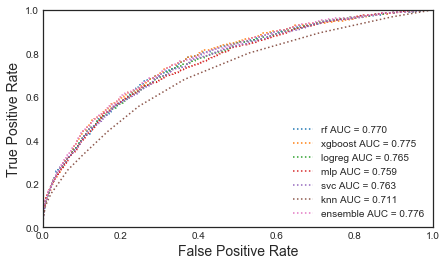

time: 5.08 s


In [99]:
stacked_roc(x_test, y_test, models_dic, first_bold=False)

# 

# variable importance
* first: find the top N (default=10) most important variables for each model
* second: make a set of all unique variables present in the combined list of all models top N variables = varimp_set
* find the variable importances for each model for varimp_set variables
* scale the variable importance for each model relative to the MOST IMPORTANT VARIABLE:
 * ie: var1= 50 (max); var2= 25; var3= 5 --> varimp: var1=100, var2=50, var3=10
* plot these as a line plot in descending order for the best performing model

In [100]:
from parameters import n_varimp

time: 745 µs


In [101]:
def find_N_varimp_set(x_train, models_dic):
    """
    function that takes in a dictionary of models and the x_train dataframe and returns the set of variables present in the combined list of each model's top N most important variables.
    1) find top N variables for each model
    2) make list of all models top N
    3) filter to only unique values in list = varimp_names
    """
    global n_varimp
    features_dic={}
    top_set_dic={}

    for model_name in models_dic.keys():
        model= models_dic[model_name]
        print(model_name)
        if model_name in ['knn','ensemble', 'mlp']:
            pass
        elif model_name in ['logreg','svc']:
            feature_importance = abs(model.coef_[0])
            sorted_idx = np.argsort(feature_importance)[-n_varimp:]#[0]
            features =list(np.array(x_train.columns)[sorted_idx][-n_varimp:])
            features_dic.update( {model_name :features } )
        else:
            feat_importances = pd.Series(model.feature_importances_, index=x_train.columns)
            features=feat_importances.nlargest(n_varimp).sort_values()
            features=list(features.reset_index()['index'])
            features_dic.update( {model_name :features } )
    #######
    set_features=[]

    for features in features_dic.values():
        set_features=set_features+features
    set_features=set(set_features)
    varimp_names=list(set_features)

    return(varimp_names)

time: 33.2 ms


In [102]:
def topN_rel_imp(models_dic, varimp_names):
    """
    input:dictionary of models and the top N set of important variables among models
    output: relative variable importance for each model of all set(varimp_names) variables.
    note: relative variable importance determined by dividing each variable importance by the value of the most important variable. this makes all values a comparison to the most important varaible:
    ie 50 rel variable importance = half as important as the most important variable
    """
    
    # finding the index of the set(varimp_names) in the dataframe.  
    #getting index of the set(top10) variables in x_train
    xtrain_column_index_list=[]
    for element in varimp_names:
        variable_index=list(x_train).index(element)
        xtrain_column_index_list.append(variable_index)
    
    top_set_dic={} #instantiating dictionary
    for model_name in models_dic.keys(): ##now that we have set of top N variables for each model. we can make relative importance for all unique variables in the set
        model= models_dic[model_name]
        if model_name in ['knn','ensemble', 'mlp']:
            pass
        
        elif model_name in ['logreg','svc']: 
            imp= abs(model.coef_[0])[xtrain_column_index_list]
            rel_imp=100.0 * (imp / imp.max())
            features =list(np.array(x_train.columns)[xtrain_column_index_list])#[-n_varimp:])
            top_set= pd.Series(rel_imp,features).sort_values()
            top_set_dic.update( {model_name :top_set } )

        else:
            imp=pd.Series(models_dic[model_name].feature_importances_, index=x_train.columns)[xtrain_column_index_list]
            imp=imp.sort_values()
            rel_imp=100.0 * (imp / imp.max())
            features =list(np.array(x_train.columns)[xtrain_column_index_list])
            top_set= rel_imp
            top_set_dic.update( {model_name :top_set } )

    return(top_set_dic)

time: 45 ms


In [103]:
def roc_name_adjust(varimp_names):
    """
    cleans up the column names for the variable importance plot for publishing
    """
    adjusted_names=[]
    mapper={'vent_recieved_2.0': 'mechanical ventilation recieved',
            'vent_recieved_1.0': 'oxygen ventilation recieved',
            'vent_recieved_1.0': 'no ventilation recieved',
            'pao2fio2ratio':'PaO2:FiO2',
#             'pao2fio2ratio_(475, 3000]': 'PaO2:FiO2 (475-3000)',
#             'pao2fio2ratio_(200, 333]': 'PaO2:FiO2 (200-333)',
#             'pao2fio2ratio_(333, 475]': 'PaO2:FiO2 (333-475)',
            'ipco2_>50': 'pCO2 (>50)',
            'ibands_>10': 'bands (>10)',
            'ibands_absent': 'bands (missing)'}
    
    for element in varimp_names:
        if element in mapper.keys():
            element= mapper[element]
            adjusted_names.append(element)
        elif "_1.0" in element:
            element= element.strip("_1.0") + ' (Y/N)'
            adjusted_names.append(element)
        else:
            adjusted_names.append(element)
        
    return(adjusted_names)

time: 15.9 ms


In [104]:
def plot_topN_rel_imp(top_set_dic, varimp_names, xvar_rotation=80):
    """
    plot the variable importance plots as a lineplot
    rotation: the amount of xvar rotation
    """
    global save_boolean
    
    df_base=pd.DataFrame(index=varimp_names)  

    for model_name in top_set_dic.keys():
        df_base[model_name]= top_set_dic[model_name]

    adjusted_names=roc_name_adjust(varimp_names)
    df_base.index=adjusted_names
    df_base.sort_values('rf', ascending=False)

    plt.style.use('seaborn-ticks')
    plt.rcParams['figure.figsize'] = [10,10]#[7, 7]
    plt.plot(df_base.sort_values('rf', ascending=True))
    #plt.set_xticklabels(adjusted_names,rotation=30)
    plt.xticks(rotation=xvar_rotation)#, ha='right')
    plt.ylabel("Relative Variable Importance")
    plt.legend(list(df_base))
    
    if save_boolean==True:
        saveplot(plt,'variable_importance')

    return(df_base)

time: 33.6 ms


rf
xgboost
logreg
mlp
svc
knn
ensemble
/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/figures/16122019_24_hr_window_morecases


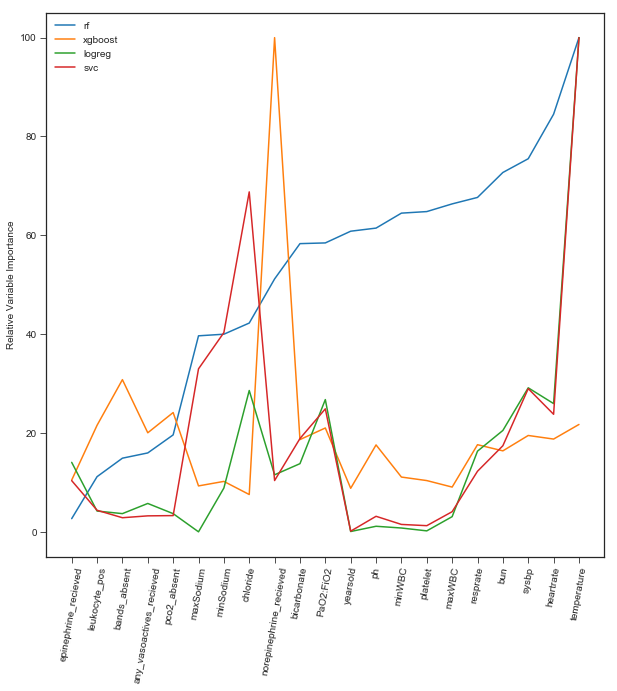

time: 774 ms


In [105]:
#find set(topN) variables
varimp_names= find_N_varimp_set(x_train, models_dic)

#find rel importance of set(topN) variables for each model
top_set_dic= topN_rel_imp(models_dic, varimp_names)

#plot the variable importance plot
topN_rel_imp_df= plot_topN_rel_imp(top_set_dic, varimp_names, xvar_rotation=80)

In [106]:
all_features=[
    'bilirubin','bun','chloride',
     'creatinine','glucose','heartrate',
     'inr','lactate','potassium',
     'ptt','resprate','sum_elix',
     'temperature','bicarbonate','diasbp',
     'hemoglobin','meanartpress','mingcs',
     'pao2fio2ratio','ph','platelet',
     'spo2','sysbp','maxCalcium',
     'maxSodium','maxWBC','minCalcium',
     'minSodium','minWBC','weight',
     'yearsold','ethnicity_black','ethnicity_hispanic',
     'ethnicity_unknown/other','ethnicity_white/nonhispanic','bands_>10',
     'bands_absent','pco2_>50','pco2_absent',
     'any_vasoactives_recieved','leukocyte_pos','nitrite_pos',
     'vent_recieved_None','vent_recieved_Oxygen','dobutamine_recieved',
     'gender_M','gender_NA','dopamine_recieved',
     'epinephrine_recieved','norepinephrine_recieved','phenylephrine_recieved',
     'rrt_recieved','vasopressin_recieved','cancer_elix_no_cancer_cormorb'
]

time: 7.93 ms


# Model Saving

In [107]:
def model_save(model, model_name):
    import pickle
    modelpath=str(repository_path)+'/models/{}_{}'.format(date,folder)

    if not os.path.exists(modelpath):
        print(modelpath)
        os.makedirs(modelpath)

    filename = str(modelpath)+'/finalized_{}.sav'.format(model_name)
    pickle.dump(model, open(filename, 'wb'))

time: 6.71 ms


In [108]:
model_save(xgboost,'xgboost')
model_save(rf,'rf')
model_save(logreg,'logreg')
model_save(svc,'svc')
model_save(knn,'knn')
model_save(mlp,'mlp')
model_save(ensemble,'ensemble')

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/models/16122019_24_hr_window_morecases
time: 277 ms


In [109]:
folder

'24_hr_window_morecases'

time: 3.15 ms


In [110]:
date

'16122019'

time: 2.12 ms


cool model debugging code, useful to make validation curves across hyperparameters:

In [ ]:
# def val_curve_plot(train_scoreNum, test_scoreNum, param_range, param_name, rename_x_tick=False, param_range_name=['0','1']):
#     """quick function to plot a validation curve across different hyperparameters"""
#     plt.rcParams['figure.figsize'] = [7, 4]
    
#     train_scores_mean = np.mean(train_scoreNum, axis=1)
#     train_scores_std = np.std(train_scoreNum, axis=1)
#     test_scores_mean = np.mean(test_scoreNum, axis=1)
#     test_scores_std = np.std(test_scoreNum, axis=1)

#     plt.title("Validation Curve with RF and parameter:{}".format(param_name))
#     plt.xlabel(r"$\gamma$")
#     plt.ylabel("Score")
#     plt.ylim(0.6, 1.1)
#     try:
#         plt.xlim(0, max(param_range))
#     except TypeError:
#         pass
#     lw = 2

#     if rename_x_tick==False:
#         param_range_name=param_range
#     plt.errorbar(param_range_name,train_scores_mean, yerr=train_scores_std, alpha=0.6, color='darkorange', lw=lw, label='train')
#     plt.errorbar(param_range_name,test_scores_mean, yerr=test_scores_std, alpha=0.6, color='blue', lw=lw, label='test')
#     plt.legend(loc='best')
#     plt.show()

In [ ]:
# from sklearn.model_selection import validation_curve

# param_range=[2, 10, 15, 25, 35, 50, 200]#[100, 300, 500, 750, 800, 1200]

# train_scoreNum, test_scoreNum = validation_curve(
#                                 RandomForestClassifier(),
#                                 X = x, y = y, 
#                                 param_name = 'n_estimators', 
#                                 param_range = param_range, cv = 5)

# val_curve_plot(train_scoreNum, test_scoreNum, param_range, param_name='n_estimators')

In [ ]:
#list(x_train2.loc[:,[x for x in list(x_train2) if x not in categorical]])

# exploring LIME visualization package (depreciated at current point)

In [ ]:
# x_train2=x_train.copy()

In [ ]:
# # trying to get LIME package working
# import lime
# import lime.lime_tabular

In [ ]:
# explainer = lime.lime_tabular.LimeTabularExplainer(np.array(x_train), feature_names=list(x_train), class_names=[0,1], discretize_continuous=True)

# explainer = lime.lime_tabular.LimeTabularExplainer(train ,feature_names = feature_names,class_names=class_names,
#                                                    categorical_features=categorical_features, 
#                                                    categorical_names=categorical_names, kernel_width=3

In [ ]:
# i = np.random.randint(0, x_test.shape[0])
# exp = explainer.explain_instance(np.array(x_test)[i], rf.predict_proba, num_features=len(list(x_train)), top_labels=1)
# exp.show_in_notebook(show_table=True, show_all=False)

In [ ]:
# y_test[i]

In [ ]:
# np.array(x_test)[i]

In [ ]:
# x_test.iloc[i,:5]

In [ ]:
# exp = explainer.explain_instance(np.array(x_test)[i], xgboost.predict_proba, num_features=len(list(x_train)), top_labels=1)
# exp.show_in_notebook(show_table=True, show_all=False)

Now, there is a lot going on here. First, note that the row we are explained is displayed on the right side, in table format. Since we had the show_all parameter set to false, only the features used in the explanation are displayed.

The value column displays the original value for each feature.

Note that LIME has discretized the features in the explanation. This is because we let discretize_continuous=True in the constructor (this is the default). Discretized features make for more intuitive explanations.

In [ ]:
folder